<a href="https://colab.research.google.com/github/Timochik/Hw_datascience/blob/main/Copy_of_GoIT_HW_8_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
    # Вихідний шар
    self.output_layer = DenseLayer(n_hidden_2, num_classes)


  def __call__(self, x):
    # Передача даних через перші два шари з функцією активації sigmoid та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation=0)
    x = self.layer2(x, activation=0)
    x = self.output_layer(x, activation=1)  # softmax
    return x

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Знаходження індексів максимальних значень вздовж осі класів
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))

    # Обчислення середнього значення правильних передбачень
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
    # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
    optimizer = tf.optimizers.SGD(learning_rate)

    # Активація автоматичного диференціювання
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

        # Отримаємо список оптимізованих параметрів
        trainable_variables = neural_net.trainable_variables

        # Обчислимо за ними значення градієнта
        gradients = g.gradient(loss, trainable_variables)

        # Модифікуємо параметри
        optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss

In [7]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        acc = accuracy(pred, batch_y)

        # Збереження поточної помилки та точності
        loss_history.append(loss.numpy())
        accuracy_history.append(acc.numpy())

        print(f"Step {step}, Loss: {loss.numpy()}, Accuracy: {acc.numpy()}")


Step 100, Loss: 917.4724731445312, Accuracy: 0.546875
Step 200, Loss: 783.8384399414062, Accuracy: 0.671875
Step 300, Loss: 672.174072265625, Accuracy: 0.71484375
Step 400, Loss: 785.3353271484375, Accuracy: 0.703125
Step 500, Loss: 960.6587524414062, Accuracy: 0.66796875
Step 600, Loss: 679.6159057617188, Accuracy: 0.72265625
Step 700, Loss: 680.3695068359375, Accuracy: 0.77734375
Step 800, Loss: 893.4083251953125, Accuracy: 0.734375
Step 900, Loss: 682.6366577148438, Accuracy: 0.77734375
Step 1000, Loss: 639.5388793945312, Accuracy: 0.78125
Step 1100, Loss: 765.0997314453125, Accuracy: 0.765625
Step 1200, Loss: 799.4953002929688, Accuracy: 0.77734375
Step 1300, Loss: 534.0069580078125, Accuracy: 0.82421875
Step 1400, Loss: 700.4089965820312, Accuracy: 0.78125
Step 1500, Loss: 550.6019287109375, Accuracy: 0.8046875
Step 1600, Loss: 774.8411865234375, Accuracy: 0.79296875
Step 1700, Loss: 567.3257446289062, Accuracy: 0.84375
Step 1800, Loss: 655.2780151367188, Accuracy: 0.796875
Step 1

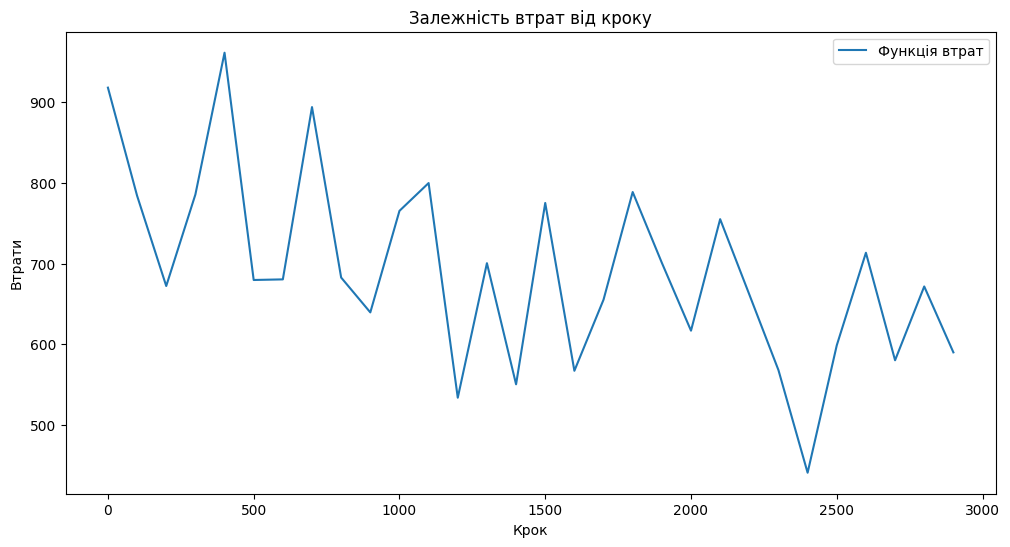

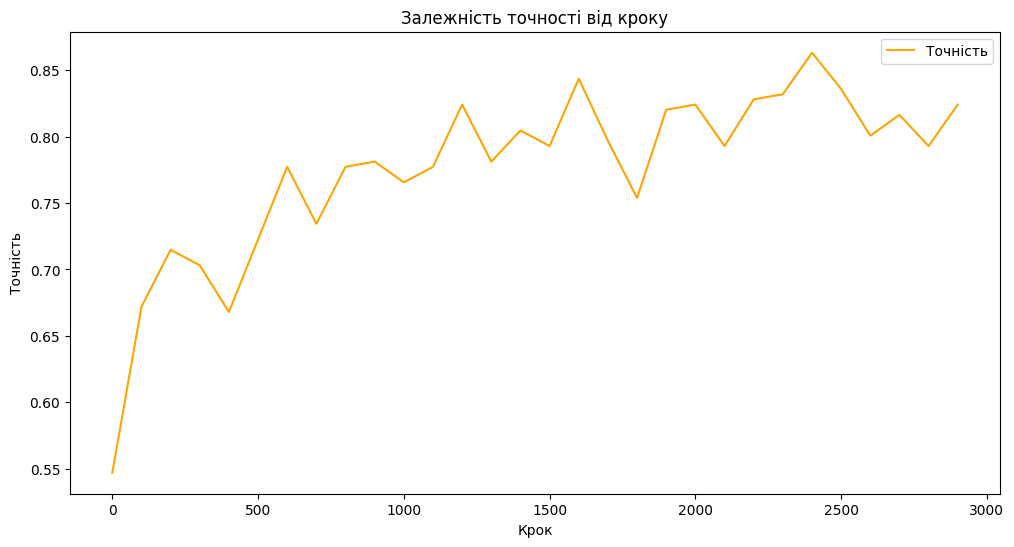

In [8]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.figure(figsize=(12, 6))
plt.plot(range(0, training_steps, display_step), loss_history, label='Функція втрат')
plt.xlabel('Крок')
plt.ylabel('Втрати')
plt.title('Залежність втрат від кроку')
plt.legend()
plt.show()

# Виведіть графік точності
plt.figure(figsize=(12, 6))
plt.plot(range(0, training_steps, display_step), accuracy_history, label='Точність', color='orange')
plt.xlabel('Крок')
plt.ylabel('Точність')
plt.title('Залежність точності від кроку')
plt.legend()
plt.show()


In [9]:
# Обчисліть точність навченої нейромережі
pred = neural_net(x_test)
test_accuracy = accuracy(pred, y_test)
print(f"Test Accuracy: {test_accuracy.numpy()}")

Test Accuracy: 0.7924000024795532


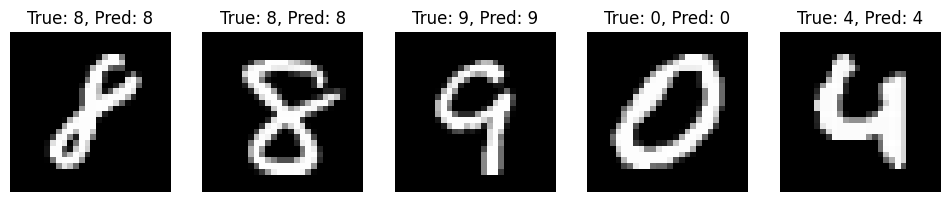

Correct Predictions: 5 out of 5


In [10]:
# Вибірка 5 випадкових зображень з тестової вибірки
random_indices = np.random.choice(len(x_test), 5, replace=False)
random_images = x_test[random_indices]
random_labels = y_test[random_indices]

# Передбачення нейронної мережі
predictions = neural_net(random_images)
predicted_labels = tf.argmax(predictions, axis=1)

# Виведення зображень та передбачень
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(random_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {random_labels[i]}, Pred: {predicted_labels.numpy()[i]}")
    plt.axis('off')
plt.show()

# Оцінка точності на 5 випадкових зображеннях
correct_predictions = np.sum(random_labels == predicted_labels.numpy())
print(f"Correct Predictions: {correct_predictions} out of 5")
